# Impact calculations with data from OpenStreetMap
## Paper Sketch openstreetmap & lines_polys_handler modules

In [1]:
import matplotlib.pyplot as plt
import shapely
import contextily as ctx
from pathlib import Path
from datetime import datetime
import numpy as np
import pandas as pd

from climada.util.api_client import Client
import climada.util.lines_polys_handler as u_lp
from climada.engine.impact_calc import ImpactCalc
from climada.entity.impact_funcs import ImpactFuncSet, ImpactFunc
from climada.entity.impact_funcs.storm_europe import ImpfStormEurope
from climada.entity import Exposures
from climada.entity import LitPop
from climada import CONFIG

from climada_petals.entity.exposures.openstreetmap.osm_dataloader import OSMRaw, OSMFileQuery
from climada_petals.entity.exposures.openstreetmap.osm_dataloader import DICT_CIS_OSM

### Getting OSM Files

In [2]:
# download osm.pbf file for Switzerland from geofabrik
DATA_DIR = CONFIG.exposures.openstreetmap.local_data.dir()
OSMRaw().get_data_geofabrik('CHE', file_format='pbf', save_path=DATA_DIR)

2023-04-27 12:22:53,749 - climada_petals.entity.exposures.openstreetmap.osm_dataloader - INFO - file already exists as /Users/evelynm/climada/data/openstreetmap/switzerland-latest.osm.pbf


### Extracting geo-data from OSM files

In [4]:
DICT_CIS_OSM.keys()

dict_keys(['education', 'healthcare', 'water', 'telecom', 'road', 'main_road', 'rail', 'air', 'gas', 'oil', 'power', 'wastewater', 'food', 'buildings'])

In [5]:
# Initiate a OSMFileQuery instance with path to the downloaded file
SwissFileQuery = OSMFileQuery(Path(DATA_DIR,'switzerland-latest.osm.pbf'))

## Healthcare infrastructure

In [29]:
gdf_health = SwissFileQuery.retrieve_cis('healthcare')

2023-03-23 18:41:59,152 - climada_petals.entity.exposures.openstreetmap.osm_dataloader - INFO - query is finished, lets start the loop


extract points: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1926/1926 [00:23<00:00, 81.33it/s]

2023-03-23 18:42:46,602 - climada_petals.entity.exposures.openstreetmap.osm_dataloader - INFO - query is finished, lets start the loop



extract multipolygons: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1403/1403 [01:09<00:00, 20.20it/s]
/Users/evelynm/climada_petals/climada_petals/entity/exposures/openstreetmap/osm_dataloader.py:561: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gdf = gdf.append(


In [30]:
# Pre-processing: duplicate entry removal

In [31]:
def _find_duplicates(overlap_gdf):
    indices_dupl = np.unique([index_right for index_right, index_left in zip(overlap_gdf.index_right, overlap_gdf.index_left)
                    if index_right != index_left])
    indices_dupl = indices_dupl[:int(len(indices_dupl/2))] # only first half of duplicates should be removed!
    return indices_dupl

def _remove_duplicates(orig_gdf, indices_dupl):
    indices_keep = list(set(orig_gdf.index).difference(set(indices_dupl)))
    return orig_gdf.loc[indices_keep]

def find_remove_duplicates(orig_gdf):
    if 'index' in orig_gdf.columns:
        orig_gdf = orig_gdf.drop('index', axis=1)
    overlap_gdf = orig_gdf.sjoin(orig_gdf)
    if 'index_left' not in overlap_gdf.columns:
        overlap_gdf = overlap_gdf.reset_index()
        overlap_gdf = overlap_gdf.rename({'index':'index_left'}, axis=1)  
    indices_dupl = _find_duplicates(overlap_gdf)
    return _remove_duplicates(orig_gdf, indices_dupl)   

In [32]:
gdf_health = gdf_health.reset_index(drop=True)
gdf_health_pnt = gdf_health[gdf_health.geometry.type=='Point']
gdf_health_pnt['geometry'] = gdf_health_pnt.geometry.buffer(0.001) # ca. 100m buffer
gdf_health_poly = gdf_health[gdf_health.geometry.type=='MultiPolygon']

/var/folders/jm/4przql117d9gb9g4hb45fd4c0000gp/T/ipykernel_57237/1801640668.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_health_pnt['geometry'] = gdf_health_pnt.geometry.buffer(0.001) # ca. 100m buffer


In [33]:
gdf_health_pnt = find_remove_duplicates(gdf_health_pnt)
gdf_health_poly = find_remove_duplicates(gdf_health_poly)

In [34]:
gdf_health = pd.concat([gdf_health_pnt, gdf_health_poly])
gdf_health = find_remove_duplicates(gdf_health)
gdf_health['geometry'] = gdf_health.geometry.centroid

/var/folders/jm/4przql117d9gb9g4hb45fd4c0000gp/T/ipykernel_57237/2613931195.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_health['geometry'] = gdf_health.geometry.centroid


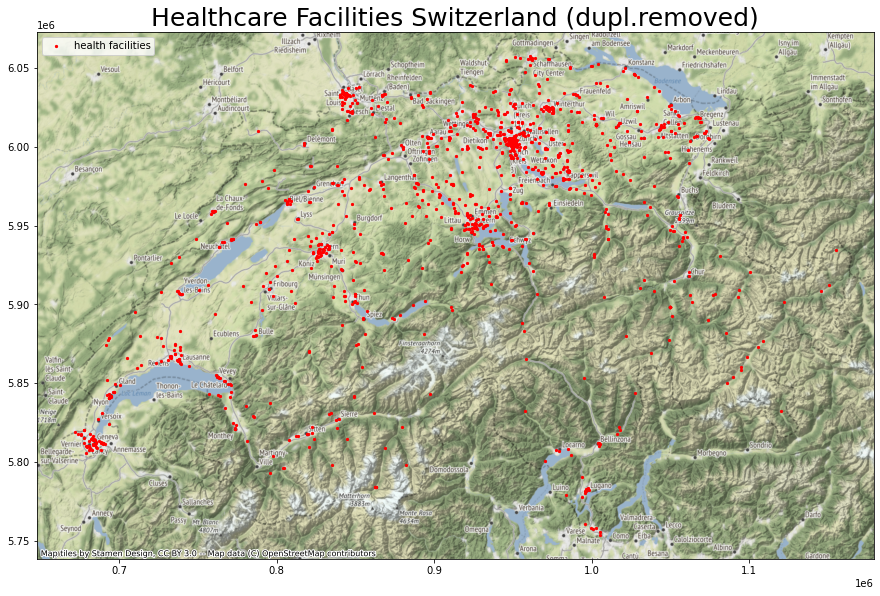

In [190]:
ax = gdf_health.set_crs(epsg=4326).to_crs(epsg=3857).plot(figsize=(15, 15), alpha=1, markersize=5, color='red', 
                    edgecolor='red', label='health facilities')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles, loc='upper left')
ax.set_title('Healthcare Facilities Switzerland (dupl.removed)', fontsize=25)
ctx.add_basemap(ax)
plt.show()

## Education, or Airports (or similar)

In [35]:
gdf_airports_orig = SwissFileQuery.retrieve_cis('air')

2023-03-23 18:45:43,280 - climada_petals.entity.exposures.openstreetmap.osm_dataloader - INFO - query is finished, lets start the loop


extract multipolygons: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:45<00:00,  3.06s/it]


In [36]:
# pre-processing: duplicate entry removal
import copy
gdf_airports = copy.deepcopy(gdf_airports_orig.reset_index(drop=True))
gdf_airports_pnt = gdf_airports[gdf_airports.geometry.type=='Point']
gdf_airports_pnt['geometry'] = gdf_airports_pnt.geometry.buffer(0.001) # ca. 100m buffer
gdf_airports_poly = gdf_airports[gdf_airports.geometry.type=='MultiPolygon']

/var/folders/jm/4przql117d9gb9g4hb45fd4c0000gp/T/ipykernel_57237/2794811889.py:5: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_airports_pnt['geometry'] = gdf_airports_pnt.geometry.buffer(0.001) # ca. 100m buffer


In [37]:
gdf_airports_poly = find_remove_duplicates(gdf_airports_poly)
gdf_airports_pnt = find_remove_duplicates(gdf_airports_pnt)

In [38]:
gdf_airports = pd.concat([gdf_airports_pnt, gdf_airports_poly])
gdf_airports = find_remove_duplicates(gdf_airports)
gdf_airports['geometry'] = gdf_airports.geometry.centroid

/var/folders/jm/4przql117d9gb9g4hb45fd4c0000gp/T/ipykernel_57237/1963958413.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_airports['geometry'] = gdf_airports.geometry.centroid


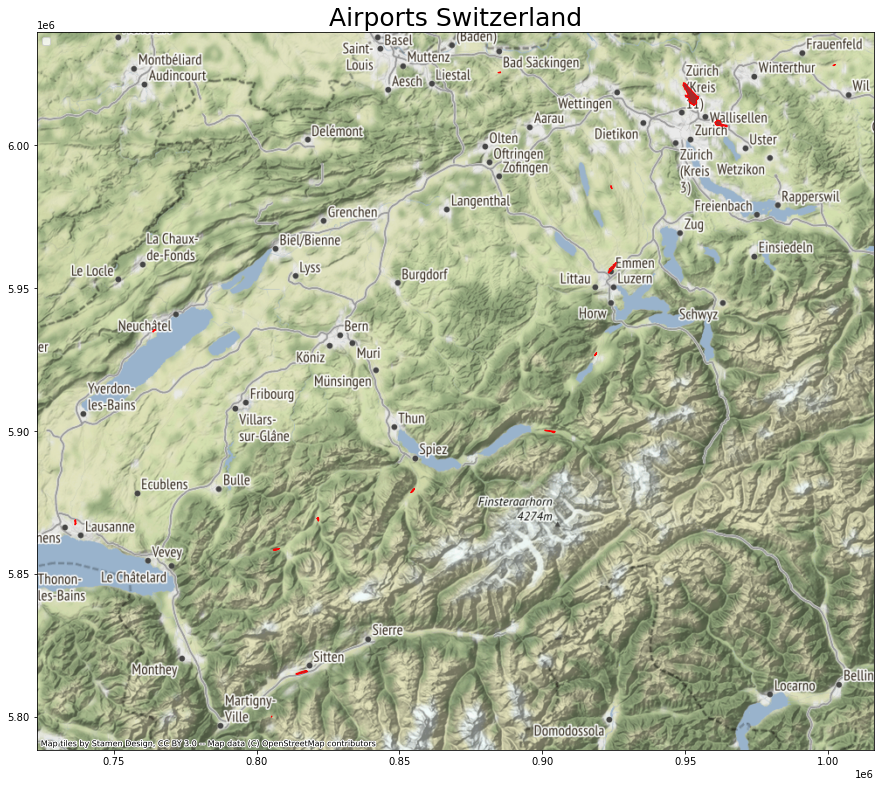

In [317]:
# plot results
ax = gdf_airports_orig.set_crs(epsg=4326).to_crs(epsg=3857).plot(figsize=(15, 15), alpha=1, markersize=5, color='brown', 
                    edgecolor='red', label='airports')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles, loc='upper left')
ax.set_title('Airports Switzerland', fontsize=25)
ctx.add_basemap(ax)
plt.show()

## Railways

In [6]:
osm_keys=['railway', 'name']
osm_query="railway='rail' or railway='tram' or railway='light_rail' or railway='narrow_gauge'"

gdf_rails = SwissFileQuery.retrieve('lines', osm_keys, osm_query)

2023-04-27 12:23:56,863 - climada_petals.entity.exposures.openstreetmap.osm_dataloader - INFO - query is finished, lets start the loop


extract lines: 100%|████████████████████████████████████████████████████████████████| 50514/50514 [00:21<00:00, 2315.31it/s]


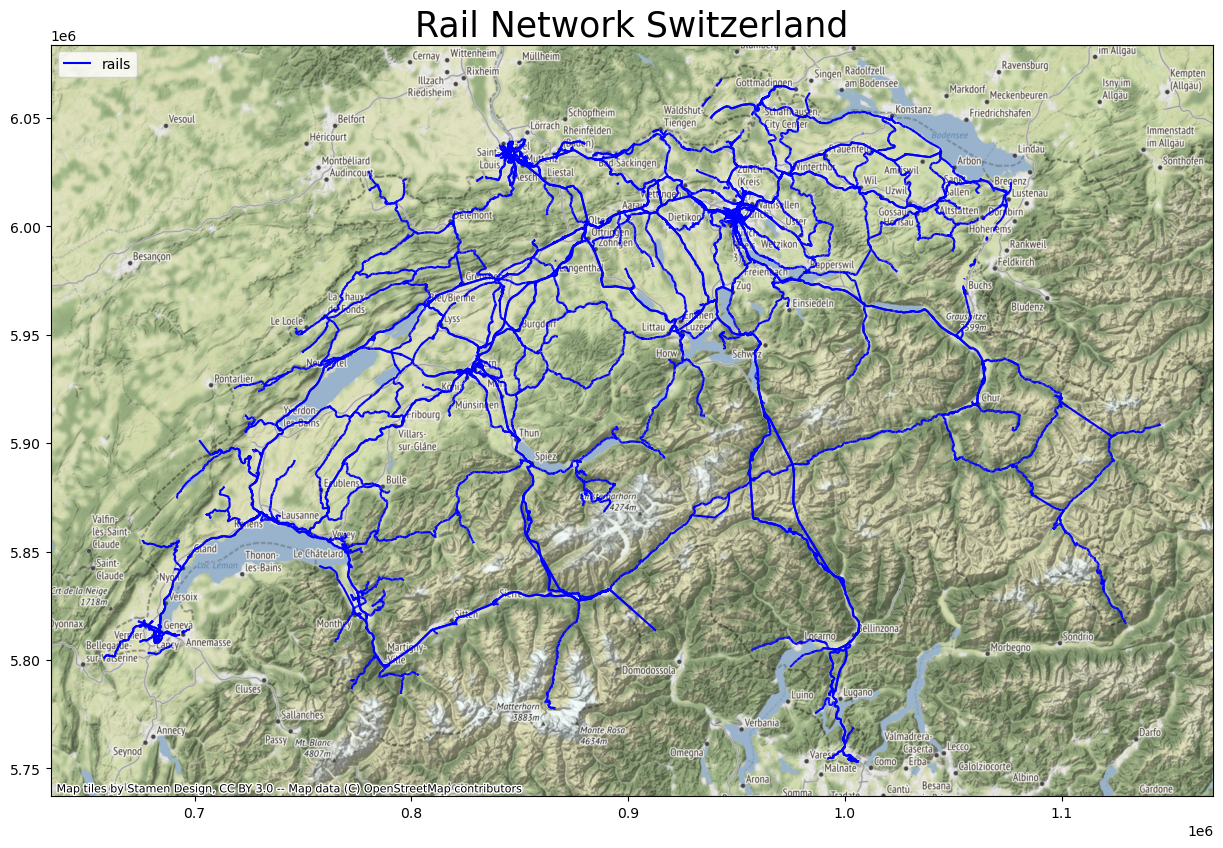

In [7]:
# plot results
ax = gdf_rails.set_crs(epsg=4326).to_crs(epsg=3857).plot(figsize=(15, 15), alpha=1, markersize=5, color='blue', 
                    edgecolor='blue', label='rails')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles, loc='upper left')
ax.set_title('Rail Network Switzerland', fontsize=25)
ctx.add_basemap(ax)
plt.show()

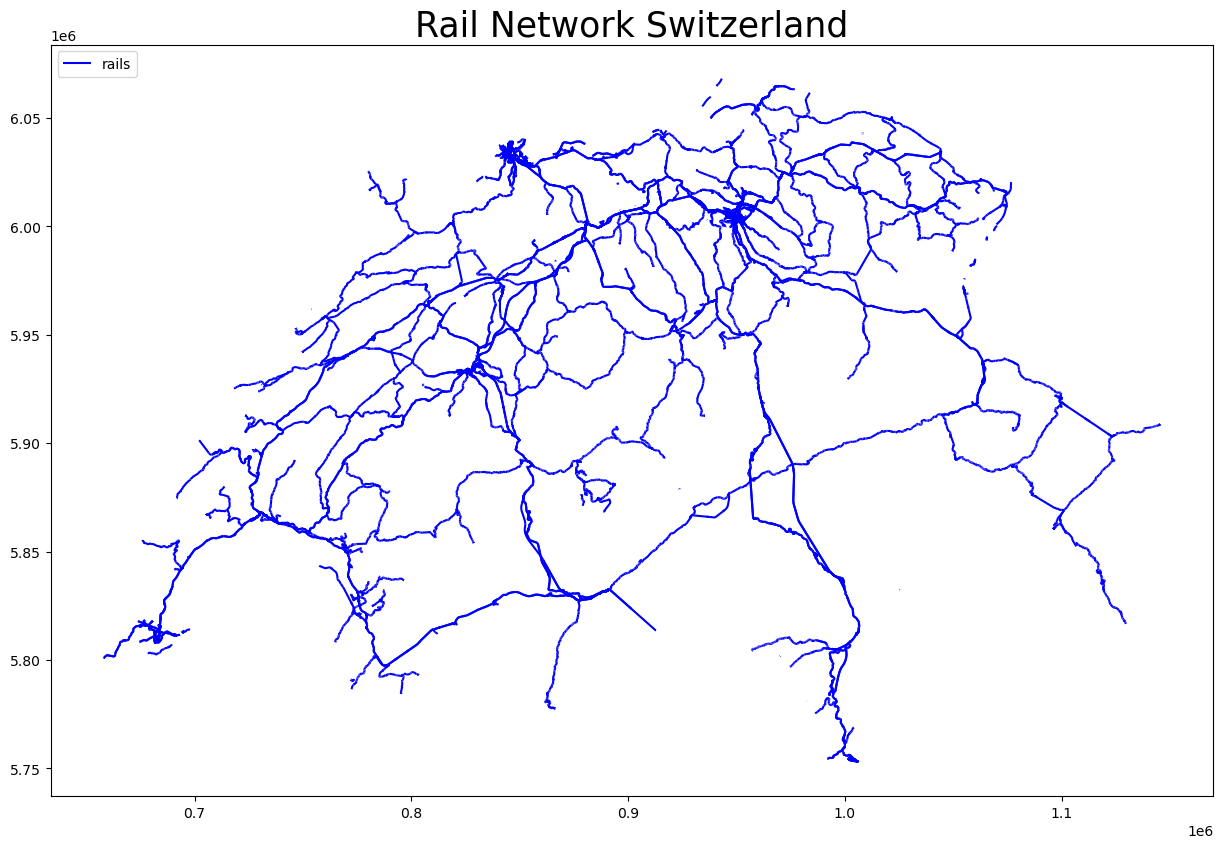

In [8]:
ax = gdf_rails.set_crs(epsg=4326).to_crs(epsg=3857).plot(figsize=(15, 15), alpha=1, markersize=5, color='blue', 
                    edgecolor='blue', label='rails')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles, loc='upper left')
ax.set_title('Rail Network Switzerland', fontsize=25)
plt.show()

## Forests 

In [41]:
# Forests in Switzerland
osm_keys = ['landuse']
osm_query = "landuse='forest'"
gdf_forest = SwissFileQuery.retrieve('multipolygons', osm_keys, osm_query)

2023-03-23 18:47:59,090 - climada_petals.entity.exposures.openstreetmap.osm_dataloader - INFO - query is finished, lets start the loop


extract multipolygons: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 76090/76090 [00:51<00:00, 1487.45it/s]


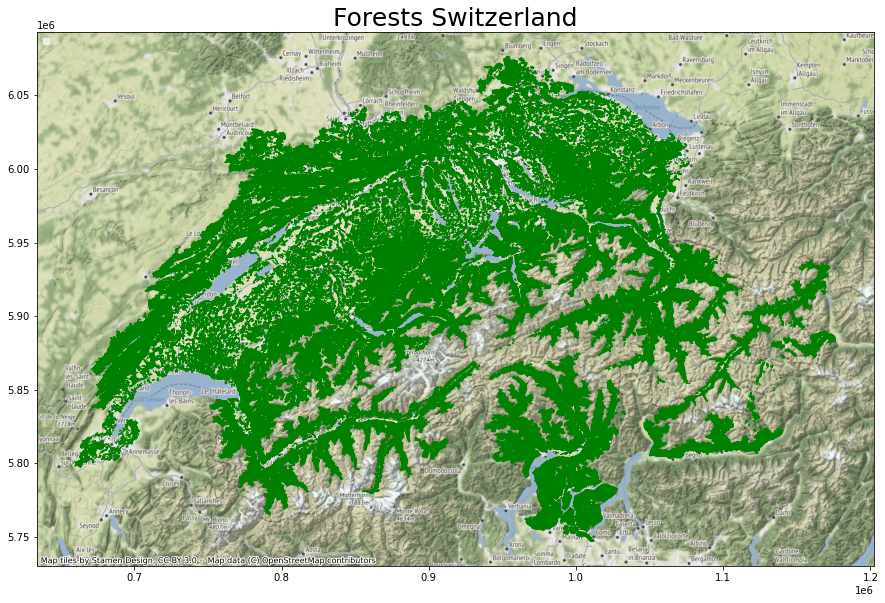

In [194]:
# plot results
ax = gdf_forest.set_crs(epsg=4326).to_crs(epsg=3857).plot(figsize=(15, 15), alpha=1, markersize=5, color='green', 
                    edgecolor='green', label='forest')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles, loc='upper left')
ax.set_title('Forests Switzerland', fontsize=25)
ctx.add_basemap(ax)
plt.show()

In [42]:
# do some cleaning: only valid shapes, not very tiny ones
import shapely
def make_valid(geometry):
    if geometry.is_valid:
        return geometry
    return geometry.buffer(0.0001)

In [43]:
gdf_forest['geometry'] = gdf_forest.apply(lambda row: make_valid(row.geometry), axis=1)
gdf_forest = gdf_forest[gdf_forest['geometry'].area > 1e-5]

/Users/evelynm/opt/anaconda3/envs/climada_env/lib/python3.9/site-packages/pandas/core/dtypes/inference.py:383: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  iter(obj)  # Can iterate over it.
/Users/evelynm/opt/anaconda3/envs/climada_env/lib/python3.9/site-packages/pandas/core/dtypes/inference.py:384: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  len(obj)  # Has a length associated with it.
/Users/evelynm/opt/anaconda3/envs/climada_env/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1981: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  numbe

In [ ]:
# consumes too much memory
# shapely.ops.unary_union(gdf_forest.geometry)
# shapely.ops.unary_union(gdf_forest['geometry'][gdf_forest['geometry'].type=='MultiPolygon'])

## UNESCO Cultural Heritage Sites

In [44]:
unesco_query = {
    'osm_keys': ['heritage_operator', 'name', 'heritage'],
    'osm_query': "heritage_operator='whc'"
}

In [45]:
gdf_list = []
for shape in ['points', 'lines', 'multipolygons']:
    try:
        gdf = SwissFileQuery.retrieve(shape, unesco_query['osm_keys'], unesco_query['osm_query'])
        gdf_list.append(gdf)
    except TypeError:
        print(f'{shape} not found')
gdf_unesco = pd.concat(gdf_list)
gdf_unesco

2023-03-23 18:50:06,814 - climada_petals.entity.exposures.openstreetmap.osm_dataloader - INFO - query is finished, lets start the loop


extract points: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:06<00:00,  1.26it/s]

2023-03-23 18:50:19,830 - climada_petals.entity.exposures.openstreetmap.osm_dataloader - INFO - query is finished, lets start the loop



extract lines: 0it [00:10, ?it/s]

2023-03-23 18:50:41,858 - climada_petals.entity.exposures.openstreetmap.osm_dataloader - INFO - query is finished, lets start the loop



extract multipolygons: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:46<00:00, 15.46s/it]


osm_id heritage_operator                          name heritage  \
0    26863957               whc             Monte San Giorgio        1   
1  1453589407               whc          Morges - Les Roseaux        1   
2  1453589408               whc   Morges - Stations de Morges        1   
3  2194901120               whc                      Altstadt        1   
4  2195309046               whc  UNESCO-Welterbe - Lobsigesee        1   
5  3256406527               whc                  Castelgrande        1   
6  3256443027               whc        Castello di Montebello        1   
7  3256443038               whc     Castello di Sasso Corbaro        1   
0        None               whc                  Stiftsbezirk        1   
1        None               whc                  Stiftskirche        1   
2        None               whc                      Lochsite     None   

                                            geometry  
0                           POINT (8.94989 45.91376)  
1                           POINT (6.50810 46.51484)  
2                           POINT (6.50258 46.50943)  
3                           POINT (7.45127 46.94829)  
4                           POINT (7.29772 47.03162)  
5                           POINT (9.02175 46.19290)  
6                           POINT (9.02657 46.19129)  
7                           POINT (9.03013 46.18812)  
0  MULTIPOLYGON (((9.37641 47.42251, 9.37605 47.4...  
1  MULTIPOLYGON (((9.37747 47.42317, 9.37722 47.4...  
2  MULTIPOLYGON (((9.09276 46.99676, 9.09237 46.9...

In [ ]:
# plot results
gdf_unesco_plot = gdf_unesco.copy()
gdf_unesco_plot.geometry = gdf_unesco_plot.geometry.centroid
ax = gdf_unesco_plot.set_crs(epsg=4326).to_crs(epsg=3857).plot(figsize=(15, 15), alpha=1, markersize=100, color='red', 
                    edgecolor='red', label='UNESCO')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles, loc='upper left')
ax.set_title('UNESCO Switzerland', fontsize=25)
ctx.add_basemap(ax)
plt.show()

/var/folders/jm/4przql117d9gb9g4hb45fd4c0000gp/T/ipykernel_57237/4000003835.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_unesco_plot.geometry = gdf_unesco_plot.geometry.centroid


### Exposure Plots

In [47]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from climada.util import coordinates as u_coord
import shapely
import geopandas as gpd

In [48]:
states, cntry_shape = u_coord.get_admin1_info(['CHE'])
shp_che = shapely.ops.unary_union(cntry_shape['CHE'])
gdf_che = gpd.GeoDataFrame({'geometry':[shp_che]})

In [59]:
border = cfeature.NaturalEarthFeature('cultural', 'admin_0_countries', '50m')

fig, axes = plt.subplots(4,2, figsize=(20,25)) #subplot_kw=dict(projection=ccrs.PlateCarree())

axes = axes.flatten()

ax = gdf_unesco_plot.set_crs(epsg=4326).to_crs(epsg=3857).plot(ax=axes[0],
    alpha=1, markersize=10, color='blue', edgecolor='blue')
gdf_che.set_crs(epsg=4326).to_crs(epsg=3857).plot(ax=axes[0],
    alpha=0, markersize=10, color=None, edgecolor='blue')
ax.set_title('UNESCO Switzerland', fontsize=10)
ctx.add_basemap(ax)

ax = gdf_forest.set_crs(epsg=4326).to_crs(epsg=3857).plot(ax=axes[1],
    alpha=1, color='blue', edgecolor='blue')
ax.set_title('Forests Switzerland', fontsize=10)
ctx.add_basemap(ax)

ax = gdf_health.set_crs(epsg=4326).to_crs(epsg=3857).plot(ax=axes[2],
    alpha=1, color='blue',markersize=3, edgecolor='blue')
ax.set_title('Healthcare Facilities Switzerland', fontsize=10)
ctx.add_basemap(ax)

ax = gdf_rails.set_crs(epsg=4326).to_crs(epsg=3857).plot(ax=axes[3],
    alpha=1, color='blue',markersize=3, edgecolor='blue')
ax.set_title('Railways Switzerland', fontsize=10)
ctx.add_basemap(ax)

ax = gdf_airports.set_crs(epsg=4326).to_crs(epsg=3857).plot(ax=axes[4],
    alpha=1, markersize=10, color='blue', edgecolor='blue')
gdf_che.set_crs(epsg=4326).to_crs(epsg=3857).plot(ax=axes[4],
    alpha=0, markersize=10, color=None, edgecolor='blue')
ax.set_title('Airports Switzerland', fontsize=10)
ctx.add_basemap(ax)

ax = exp_lp.gdf.set_crs(epsg=4326).to_crs(epsg=3857).plot('value', ax=axes[6],
    alpha=1, cmap='Blues_r',markersize=1, legend=True,
    norm= colors.LogNorm(vmin=exp_lp.gdf.value.min()+1, vmax=exp_lp.gdf.value.max()),
    legend_kwds={'label':'Asset Values (US$)', 'shrink':0.8})
ax.set_title('Asset Values Switzerland', fontsize=10)
ctx.add_basemap(ax)

ax = exp_pop.gdf.set_crs(epsg=4326).to_crs(epsg=3857).plot('value', ax=axes[7],
    alpha=1, cmap='Blues_r',markersize=1, legend=True,
    norm= colors.LogNorm(vmin=exp_pop.gdf.value.min()+1, vmax=exp_pop.gdf.value.max()),
    legend_kwds={'label':'Population Count', 'shrink':0.8})
ax.set_title('Population Switzerland', fontsize=10)
ctx.add_basemap(ax)

fig.delaxes(axes[5])

fig.tight_layout()
plt.savefig('/Users/evelynm/Documents/WCR/3_PhD/10_paper outlines/Paper_OSM/exposures.png', 
                    format='png', dpi=150,
        bbox_inches=None, pad_inches=0.1,
        facecolor='auto', edgecolor='auto',
        backend=None)
plt.show()


### Loading Hazard Data

In [16]:
# Let's take european winter storms
client = Client()
ws_che = client.get_hazard('storm_europe', properties={'country_name': 'Switzerland'})

2023-03-23 17:48:17,019 - climada.hazard.base - INFO - Reading /Users/evelynm/climada/data/hazard/storm_europe/storm_europe_150arcsec_CHE/v1/WISC_prob_CHE.hdf5


In [17]:
# Let's take european winter storms
client = Client()
ws_che = client.get_hazard('storm_europe', properties={'country_name': 'Switzerland'})
ws_che = ws_che.select(orig=True)

2023-03-23 17:48:18,691 - climada.hazard.base - INFO - Reading /Users/evelynm/climada/data/hazard/storm_europe/storm_europe_150arcsec_CHE/v1/WISC_prob_CHE.hdf5


In [58]:
#print(datetime.fromordinal(int(np.min(ws_che.date))))
#print(datetime.fromordinal(int(np.max(ws_che.date))))

1940-11-01 00:00:00
2013-12-05 00:00:00


In [18]:
# Lothar happened around Dec 26, 1999
date_lothar_start = datetime(1999, 12, 25)
date_lothar_end = datetime(1999, 12, 31)

date_lothar_start_ordinal = date_lothar_start.toordinal()
date_lothar_end_ordinal = date_lothar_end.toordinal()

In [22]:
ws_lothar = ws_che.select(date=[date_lothar_start_ordinal, date_lothar_end_ordinal])
# ugly work-around for making eai_exp plot an at_event plot later --> frequency = 1
ws_lothar.frequency = np.array([1])

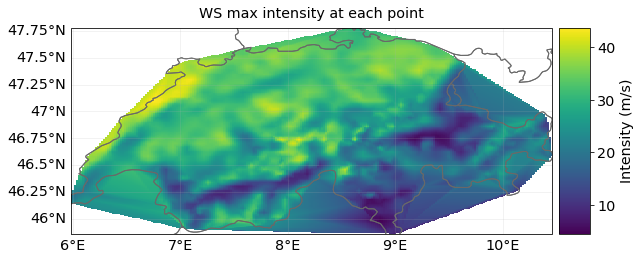

In [240]:
ws_lothar.plot_intensity(0)

<GeoAxesSubplot:title={'center':'Event ID 15229: 15229'}>

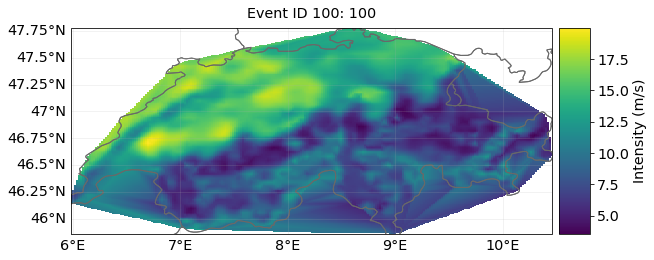

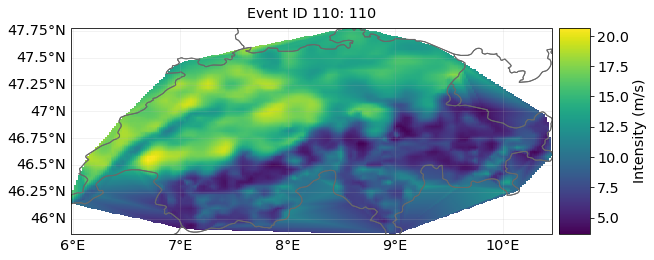

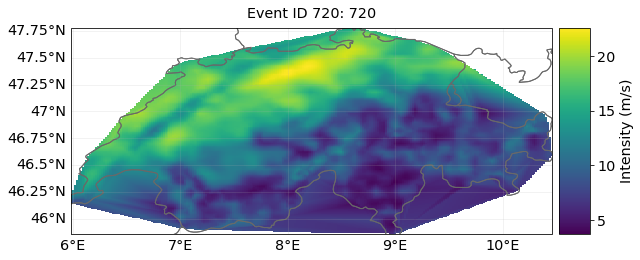

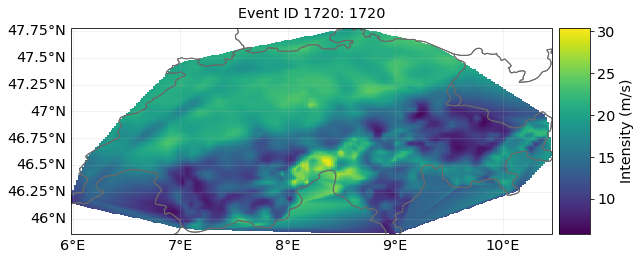

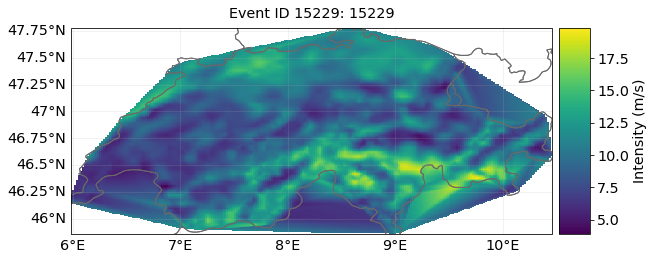

In [428]:
ws_che.plot_intensity(event=ws_che.event_id[0])
ws_che.plot_intensity(event=ws_che.event_id[10])
ws_che.plot_intensity(event=ws_che.event_id[200])
ws_che.plot_intensity(event=ws_che.event_id[500])
ws_che.plot_intensity(event=ws_che.event_id[-1])

In [61]:
# Vivian happened around Feb 27, 1990
date_vivian_start = datetime(1990, 2, 26)
date_vivian_end = datetime(1990, 2, 28)

date_vivian_start_ordinal = date_vivian_start.toordinal()
date_vivian_end_ordinal = date_vivian_end.toordinal()

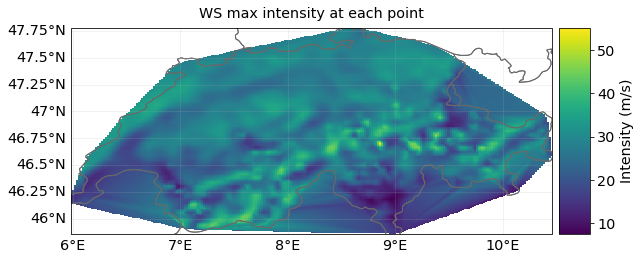

In [62]:
ws_vivian = ws_che.select(date=[date_vivian_start_ordinal, date_vivian_end_ordinal])
ws_vivian.plot_intensity(0)
# ugly work-around for making eai_exp plot an at_event plot later --> frequency = 1
ws_vivian.frequency = np.array([1])

### Impact Calculations for Line & Polygon data

### Defining impact functions

In [9]:
impf_set = ImpactFuncSet()

<Axes: title={'center': 'WS 1: Asset damages \n Welker et al. (2021)'}, xlabel='Intensity (m/s)', ylabel='Impact (%)'>

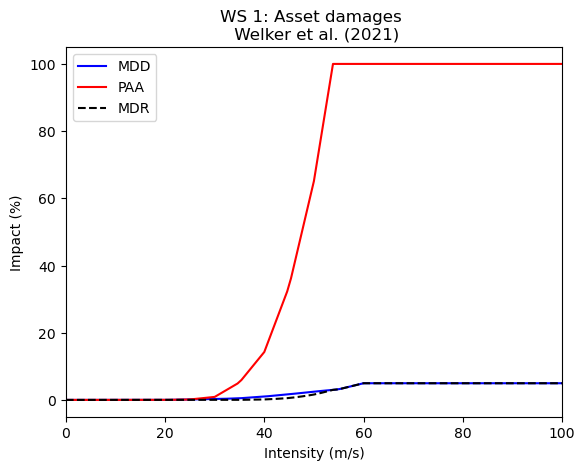

In [10]:
impf_welker = ImpfStormEurope.from_welker()
impf_welker.name = 'Asset damages \n Welker et al. (2021)'
impf_set.append(impf_welker)
impf_set.check()
impf_set.plot()

Text(0, 0.5, 'damage fraction (%)')

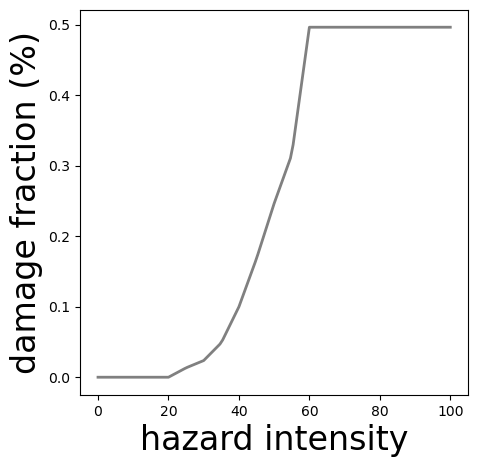

In [20]:
# "random" df for schematic plot
fig, axes = plt.subplots(1,1, figsize=(5, 5), sharey='row')
lp1 = axes.plot(impf_welker.intensity, impf_welker.mdd*10, 'gray', linewidth=2)
axes.set_xlabel('hazard intensity', fontsize=24)
axes.set_ylabel('damage fraction (%)', fontsize=24)

array([<AxesSubplot:title={'center':'WS 1: Asset damages \n Welker et al. (2021)'}, xlabel='Intensity (m/s)', ylabel='Impact (%)'>,
       <AxesSubplot:title={'center':'WS 2: Storm warning \n cat. 4'}, xlabel='Intensity (m/s)', ylabel='Impact (%)'>],
      dtype=object)

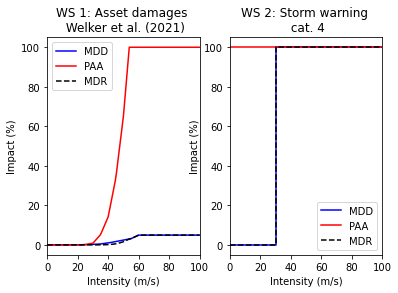

In [10]:
impf_thresh = ImpactFunc.from_step_impf([0,30.5,100],impf_id=2) # start of warning level 4 MCH
impf_thresh.haz_type = 'WS'
impf_thresh.intensity_unit = 'm/s'
impf_thresh.name = 'Storm warning \n cat. 4'
impf_set.append(impf_thresh)
impf_set.check()
impf_set.plot()

In [11]:
# not needed in the end
""" 
impf_threeblow = ImpactFunc.from_step_impf([0,42,150],impf_id=3) # tree blowdown fund
impf_threeblow.haz_type = 'WS'
impf_set.append(impf_threeblow)
impf_set.check()
impf_set.plot()
"""

" \nimpf_threeblow = ImpactFunc.from_step_impf([0,42,150],impf_id=3) # tree blowdown fund\nimpf_threeblow.haz_type = 'WS'\nimpf_set.append(impf_threeblow)\nimpf_set.check()\nimpf_set.plot()\n"

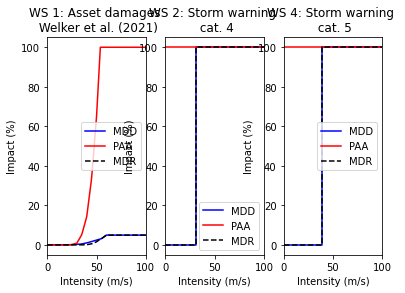

In [12]:
impf_W5 = ImpactFunc.from_step_impf([0,38.9,100],impf_id=4) # tree blowdown fund
impf_W5.haz_type = 'WS'
impf_W5.intensity_unit = 'm/s'
impf_W5.name = 'Storm warning \n cat. 5'
impf_set.append(impf_W5)
impf_set.check()
ax = impf_set.plot()

#fig = ax.get_figure()

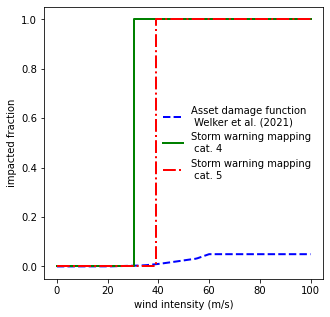

In [419]:
fig, ax = plt.subplots(1,1, figsize=(5, 5))

lp1 = ax.plot(impf_welker.intensity, impf_welker.mdd, 'b--', linewidth=2, label='Asset damage function \n Welker et al. (2021)')
ax.plot(impf_thresh.intensity, impf_thresh.mdd, 'g-', linewidth=2, label='Storm warning mapping \n cat. 4')
ax.plot(impf_W5.intensity, impf_W5.mdd, 'r-.', linewidth=2, label='Storm warning mapping \n cat. 5')
ax.set_xlabel('wind intensity (m/s)')
ax.set_ylabel('impacted fraction')
ax.legend(loc='center right', frameon=False)

plt.savefig('/Users/evelynm/Documents/WCR/3_PhD/10_paper outlines/Paper_OSM/imp_funcs_all1.png', 
                    format='png', dpi=100,
        bbox_inches=None, pad_inches=0.1,
        facecolor='auto', edgecolor='auto',
        backend=None)


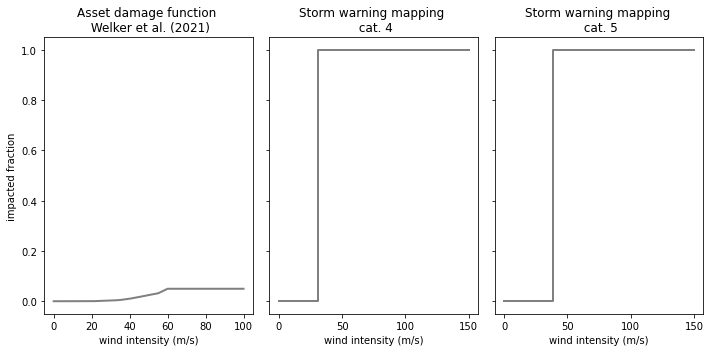

In [397]:
fig, axes = plt.subplots(1,3, figsize=(10, 5), sharey='row')

axes = axes.flatten()
lp1 = axes[0].plot(impf_welker.intensity, impf_welker.mdd, 'gray', linewidth=2)
axes[0].set_xlabel('wind intensity (m/s)')
axes[0].set_ylabel('impacted fraction')
axes[0].set_title('Asset damage function \n Welker et al. (2021)')

lp2 = axes[1].plot(impf_thresh.intensity, impf_thresh.mdd, 'gray', linewidth=2)
axes[1].set_xlabel('wind intensity (m/s)')
axes[1].set_title('Storm warning mapping \n cat. 4')

lp3 = axes[2].plot(impf_W5.intensity, impf_W5.mdd, 'gray', linewidth=2)
axes[2].set_xlabel('wind intensity (m/s)')
axes[2].set_title('Storm warning mapping \n cat. 5')

fig.tight_layout()
plt.savefig('/Users/evelynm/Documents/WCR/3_PhD/10_paper outlines/Paper_OSM/imp_funcs.png', 
                    format='png', dpi=100,
        bbox_inches=None, pad_inches=0.1,
        facecolor='auto', edgecolor='auto',
        backend=None)

### Exposures from gdfs

In [205]:
exp_health = Exposures(gdf_health)
exp_health.gdf['impf_WS'] = 2
exp_health.gdf['value'] = 1
exp_health.gdf['geometry'] = exp_health.gdf.geometry.centroid # simplify to points
exp_health.set_lat_lon()
exp_health.check()

2023-03-21 14:24:24,607 - climada.entity.exposures.base - INFO - Setting latitude and longitude attributes.
2023-03-21 14:24:24,642 - climada.entity.exposures.base - INFO - category_id not set.
2023-03-21 14:24:24,642 - climada.entity.exposures.base - INFO - cover not set.
2023-03-21 14:24:24,643 - climada.entity.exposures.base - INFO - deductible not set.
2023-03-21 14:24:24,644 - climada.entity.exposures.base - INFO - region_id not set.
2023-03-21 14:24:24,645 - climada.entity.exposures.base - INFO - centr_ not set.


/var/folders/jm/4przql117d9gb9g4hb45fd4c0000gp/T/ipykernel_47635/3092231282.py:4: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  exp_health.gdf['geometry'] = exp_health.gdf.geometry.centroid # simplify to points


In [223]:
exp_airports = Exposures(gdf_airports)
exp_airports.gdf['impf_WS'] = 2
exp_airports.gdf['value'] = 1
exp_airports.set_lat_lon()
exp_airports.check()

2023-03-21 14:27:34,540 - climada.entity.exposures.base - INFO - Setting latitude and longitude attributes.
2023-03-21 14:27:34,548 - climada.entity.exposures.base - INFO - category_id not set.
2023-03-21 14:27:34,549 - climada.entity.exposures.base - INFO - cover not set.
2023-03-21 14:27:34,550 - climada.entity.exposures.base - INFO - deductible not set.
2023-03-21 14:27:34,551 - climada.entity.exposures.base - INFO - region_id not set.
2023-03-21 14:27:34,552 - climada.entity.exposures.base - INFO - centr_ not set.


In [5]:
# Making exposures with non-point geometry data:
exp_rails = Exposures(gdf_rails)
exp_rails.gdf['impf_WS'] = 2

In [251]:
gdf_forest_42 = copy.deepcopy(gdf_forest)
exp_forest_42 = Exposures(gdf_forest_42)
exp_forest_42.gdf['impf_WS'] = 3

In [252]:
gdf_forest_W4 = copy.deepcopy(gdf_forest)
exp_forest_W4 = Exposures(gdf_forest_W4)
exp_forest_W4.gdf['impf_WS'] = 2

In [258]:
gdf_forest_W5 = copy.deepcopy(gdf_forest)
exp_forest_W5 = Exposures(gdf_forest_W5)
exp_forest_W5.gdf['impf_WS'] = 4

In [219]:
# Making exposures with non-point geometry data:
exp_airport = Exposures(gdf_airports)
exp_airport.gdf['impf_WS'] = 2

In [270]:
# UNESCO heritage sites
exp_unesco = Exposures(gdf_unesco)
exp_unesco.gdf['impf_WS'] = 2
exp_unesco.gdf['value'] = 1
exp_unesco.gdf['geometry'] = exp_unesco.gdf.geometry.centroid # simplify to points
exp_unesco.set_lat_lon()
exp_unesco.check()

2023-03-21 15:31:20,142 - climada.entity.exposures.base - INFO - Setting latitude and longitude attributes.
2023-03-21 15:31:20,146 - climada.entity.exposures.base - INFO - category_id not set.
2023-03-21 15:31:20,147 - climada.entity.exposures.base - INFO - cover not set.
2023-03-21 15:31:20,148 - climada.entity.exposures.base - INFO - deductible not set.
2023-03-21 15:31:20,149 - climada.entity.exposures.base - INFO - region_id not set.
2023-03-21 15:31:20,150 - climada.entity.exposures.base - INFO - centr_ not set.


/var/folders/jm/4przql117d9gb9g4hb45fd4c0000gp/T/ipykernel_47635/1907033712.py:5: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  exp_unesco.gdf['geometry'] = exp_unesco.gdf.geometry.centroid # simplify to points


### Exposures from LitPop

In [50]:
# asset values (1,1)
exp_lp = LitPop().from_countries(['CHE'],reference_year=1999)
exp_lp.gdf['impf_WS'] = 1

2023-03-23 19:02:51,887 - climada.entity.exposures.litpop.litpop - INFO - 
 LitPop: Init Exposure for country: CHE (756)...



Exception ignored in: <function tqdm.__del__ at 0x16c19cca0>
Traceback (most recent call last):
  File "/Users/evelynm/opt/anaconda3/envs/climada_env/lib/python3.9/site-packages/tqdm/std.py", line 1162, in __del__
    self.close()
  File "/Users/evelynm/opt/anaconda3/envs/climada_env/lib/python3.9/site-packages/tqdm/std.py", line 1281, in close
    if self.disable:
AttributeError: 'tqdm' object has no attribute 'disable'


2023-03-23 19:02:56,339 - climada.entity.exposures.base - INFO - Hazard type not set in impf_
2023-03-23 19:02:56,340 - climada.entity.exposures.base - INFO - category_id not set.
2023-03-23 19:02:56,340 - climada.entity.exposures.base - INFO - cover not set.
2023-03-23 19:02:56,341 - climada.entity.exposures.base - INFO - deductible not set.
2023-03-23 19:02:56,342 - climada.entity.exposures.base - INFO - centr_ not set.


In [51]:
# population gridded counts (0,1)
exp_pop = LitPop().from_countries(['CHE'], exponents=(0, 1), fin_mode='pop', reference_year=1999)
exp_pop.gdf['impf_WS'] = 2

2023-03-23 19:02:56,623 - climada.entity.exposures.litpop.litpop - INFO - 
 LitPop: Init Exposure for country: CHE (756)...

2023-03-23 19:03:00,498 - climada.entity.exposures.base - INFO - Hazard type not set in impf_
2023-03-23 19:03:00,499 - climada.entity.exposures.base - INFO - category_id not set.
2023-03-23 19:03:00,500 - climada.entity.exposures.base - INFO - cover not set.
2023-03-23 19:03:00,500 - climada.entity.exposures.base - INFO - deductible not set.
2023-03-23 19:03:00,501 - climada.entity.exposures.base - INFO - centr_ not set.


### Impact calculations

2023-03-21 14:25:54,422 - climada.entity.exposures.base - INFO - Matching 1155 exposures with 3057 centroids.
2023-03-21 14:25:54,424 - climada.util.coordinates - INFO - No exact centroid match found. Reprojecting coordinates to nearest neighbor closer than the threshold = 100
2023-03-21 14:25:54,434 - climada.engine.impact_calc - INFO - Calculating impact for 3465 assets (>0) and 1 events.


<GeoAxesSubplot:title={'center':'Expected annual impact'}>

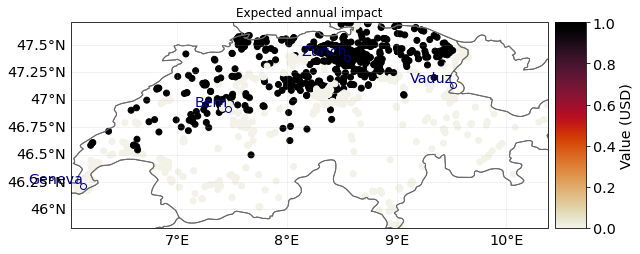

In [216]:
# Healthcare facilities
imp_health = ImpactCalc(exp_health, impf_set, ws_lothar).impact()
imp_health.plot_scatter_eai_exposure()

2023-03-21 14:27:41,726 - climada.entity.exposures.base - INFO - Matching 15 exposures with 3057 centroids.
2023-03-21 14:27:41,730 - climada.util.coordinates - INFO - No exact centroid match found. Reprojecting coordinates to nearest neighbor closer than the threshold = 100
2023-03-21 14:27:41,737 - climada.engine.impact_calc - INFO - Calculating impact for 45 assets (>0) and 1 events.


' \nonly for polygon-based exposure\n# all-in-one calculation for lines: \n# interpolate to 500 m resolution, assign each point a fixed value of 500 (metres),\n# and re-aggregate the sum of damages to the original exposure format\n\nimp_airport = u_lp.calc_geom_impact(\n    exp=exp_airports, impf_set=impf_set, haz=ws_lothar,\n    res=100, to_meters=True, disagg_met=u_lp.DisaggMethod.FIX, disagg_val=100*100,\n    agg_met=u_lp.AggMethod.SUM)\n\n# plot the impacts\nu_lp.plot_eai_exp_geom(imp_airport)\n'

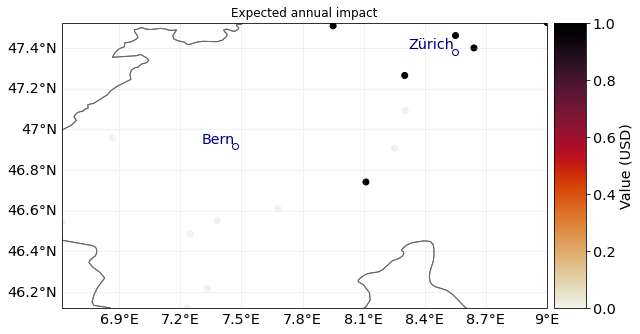

In [224]:
# Airports
imp_airport = ImpactCalc(exp_airports, impf_set, ws_lothar).impact()
imp_airport.plot_scatter_eai_exposure()

""" 
only for polygon-based exposure
# all-in-one calculation for lines: 
# interpolate to 500 m resolution, assign each point a fixed value of 500 (metres),
# and re-aggregate the sum of damages to the original exposure format

imp_airport = u_lp.calc_geom_impact(
    exp=exp_airports, impf_set=impf_set, haz=ws_lothar,
    res=100, to_meters=True, disagg_met=u_lp.DisaggMethod.FIX, disagg_val=100*100,
    agg_met=u_lp.AggMethod.SUM)

# plot the impacts
u_lp.plot_eai_exp_geom(imp_airport)
"""

In [14]:
# original gdf length:
gdf_rails = gdf_rails.set_crs('EPSG:4326')
gdf_rails_proj = gdf_rails.to_crs('EPSG:2056')
gdf_rails_proj.geometry.length.sum()
# 12450052.771180911

12450052.771180911

In [21]:
# disaggregated gdf length
gdf_rails_pnt = u_lp.gdf_to_pnts(gdf_rails, res=100, to_meters=True)
#(len(gdf_rails_pnt)*100)/12450052 #v1: 1.6278646868302238 #v2: 1.1063809211399278

2023-04-27 12:43:38,152 - climada.util.lines_polys_handler - WARNING - 2085 lines with a length < 10*resolution were found. Each of these lines is disaggregate to one point. Reaggregatint values will thus likely lead to overestimattion. Consider chosing a smaller resolution or filter out the short lines. 


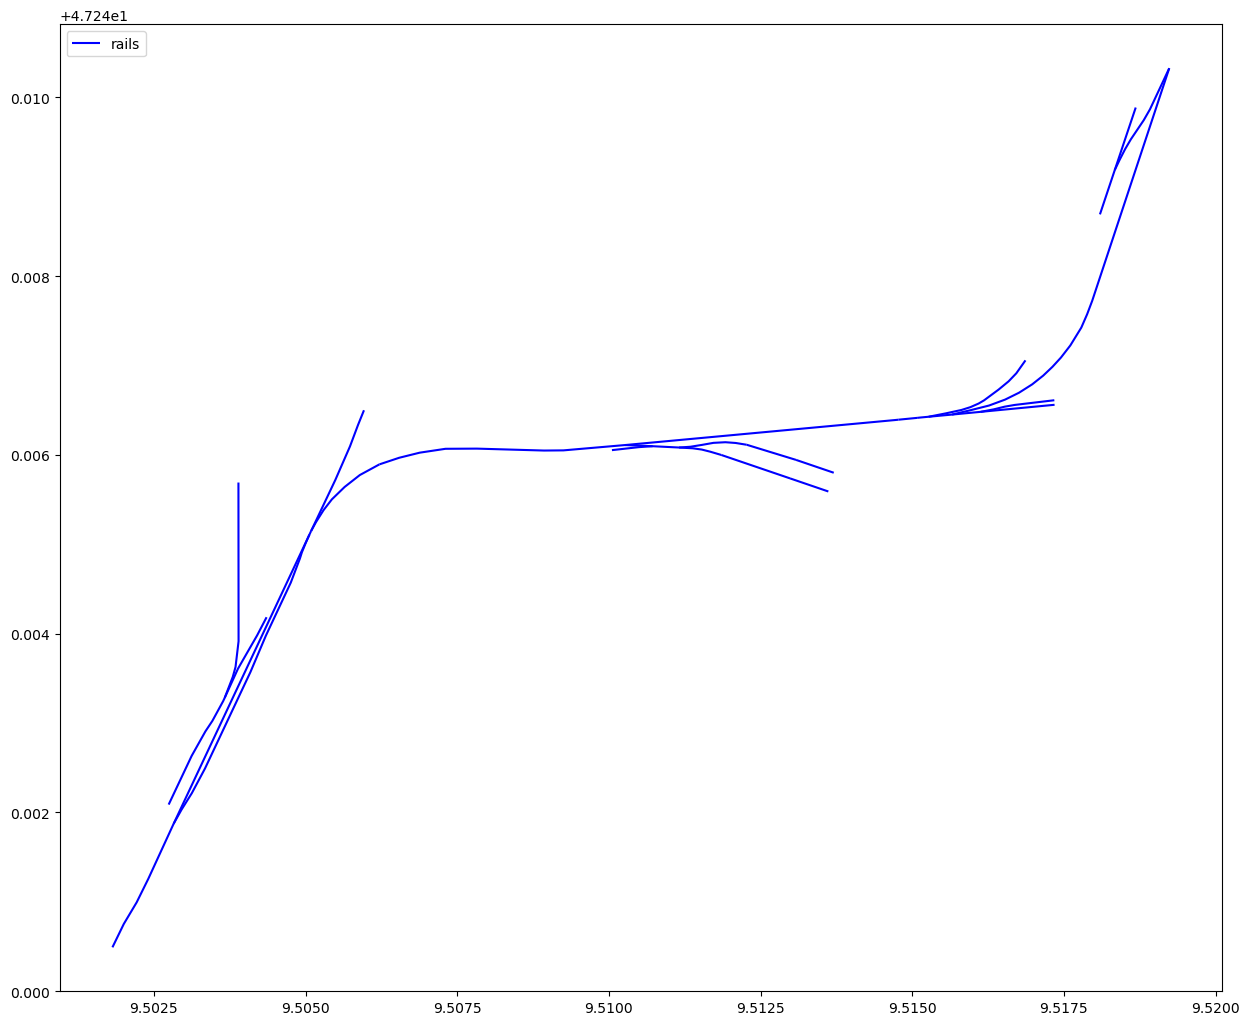

In [41]:
ax = gdf_rails.set_crs(epsg=4326).cx[ 9.4:9.7, 47.235:47.25].plot(figsize=(15, 15), alpha=1, markersize=20, color='blue', 
                    edgecolor='blue', label='rails')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles, loc='upper left')
plt.show()

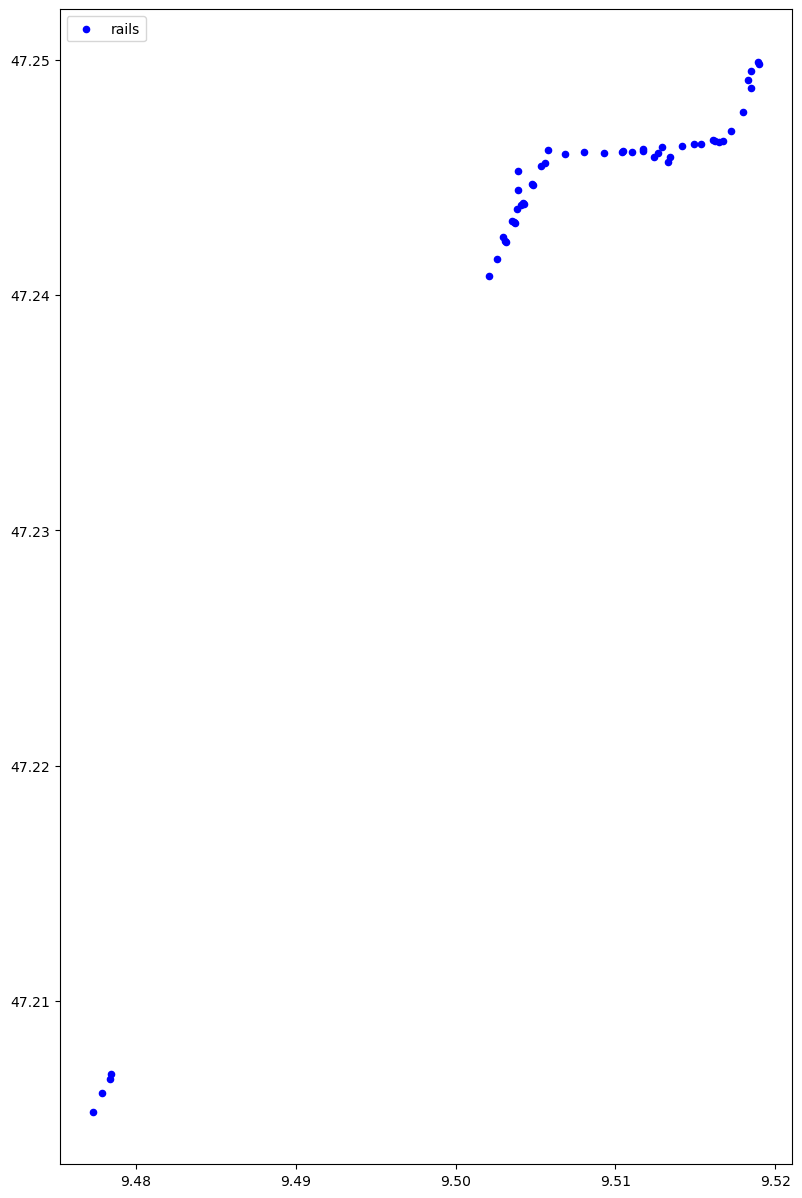

In [40]:
ax = gdf_rails_pnt.set_crs(epsg=4326).cx[ 9.4:9.7, 47.2:47.25].plot(figsize=(15, 15), alpha=1, markersize=20, color='blue', 
                    edgecolor='blue', label='rails')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles, loc='upper left')
plt.show()

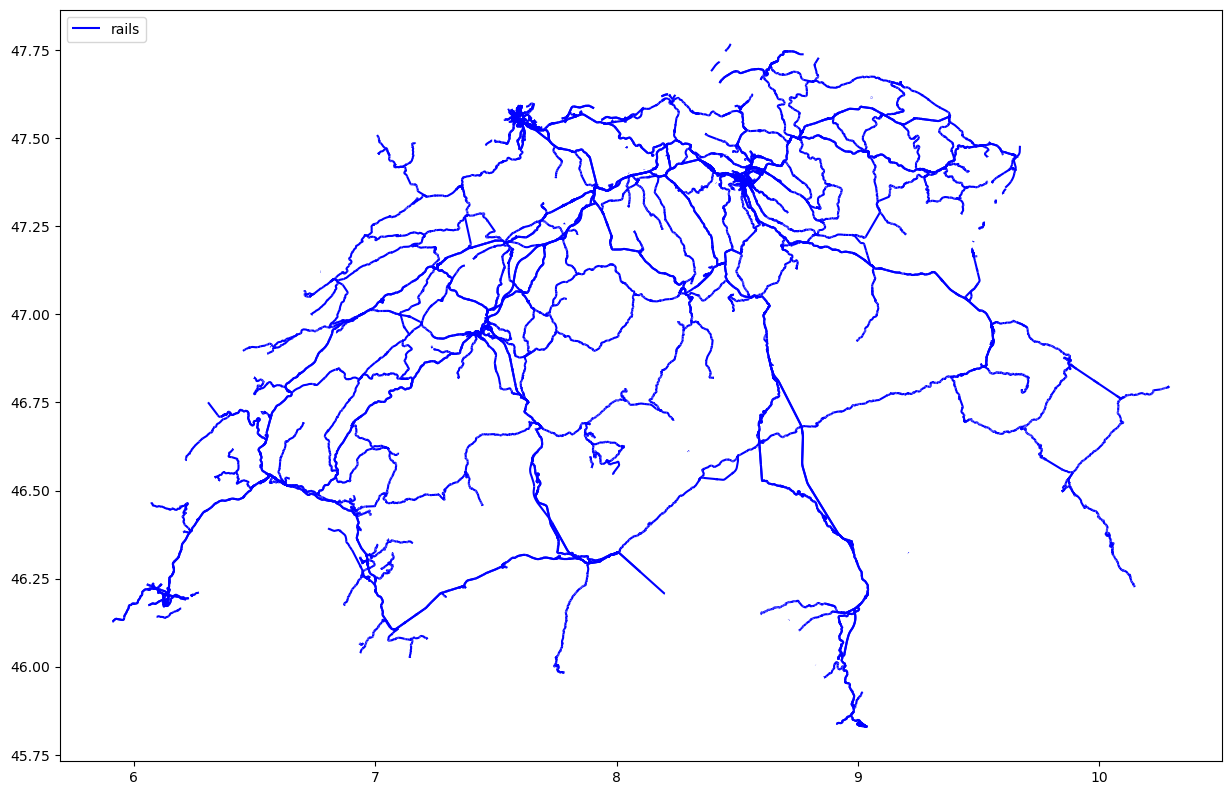

In [37]:
ax = gdf_rails.set_crs(epsg=4326).plot(figsize=(15, 15), alpha=1, markersize=20, color='blue', 
                    edgecolor='blue', label='rails')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles, loc='upper left')
plt.show()

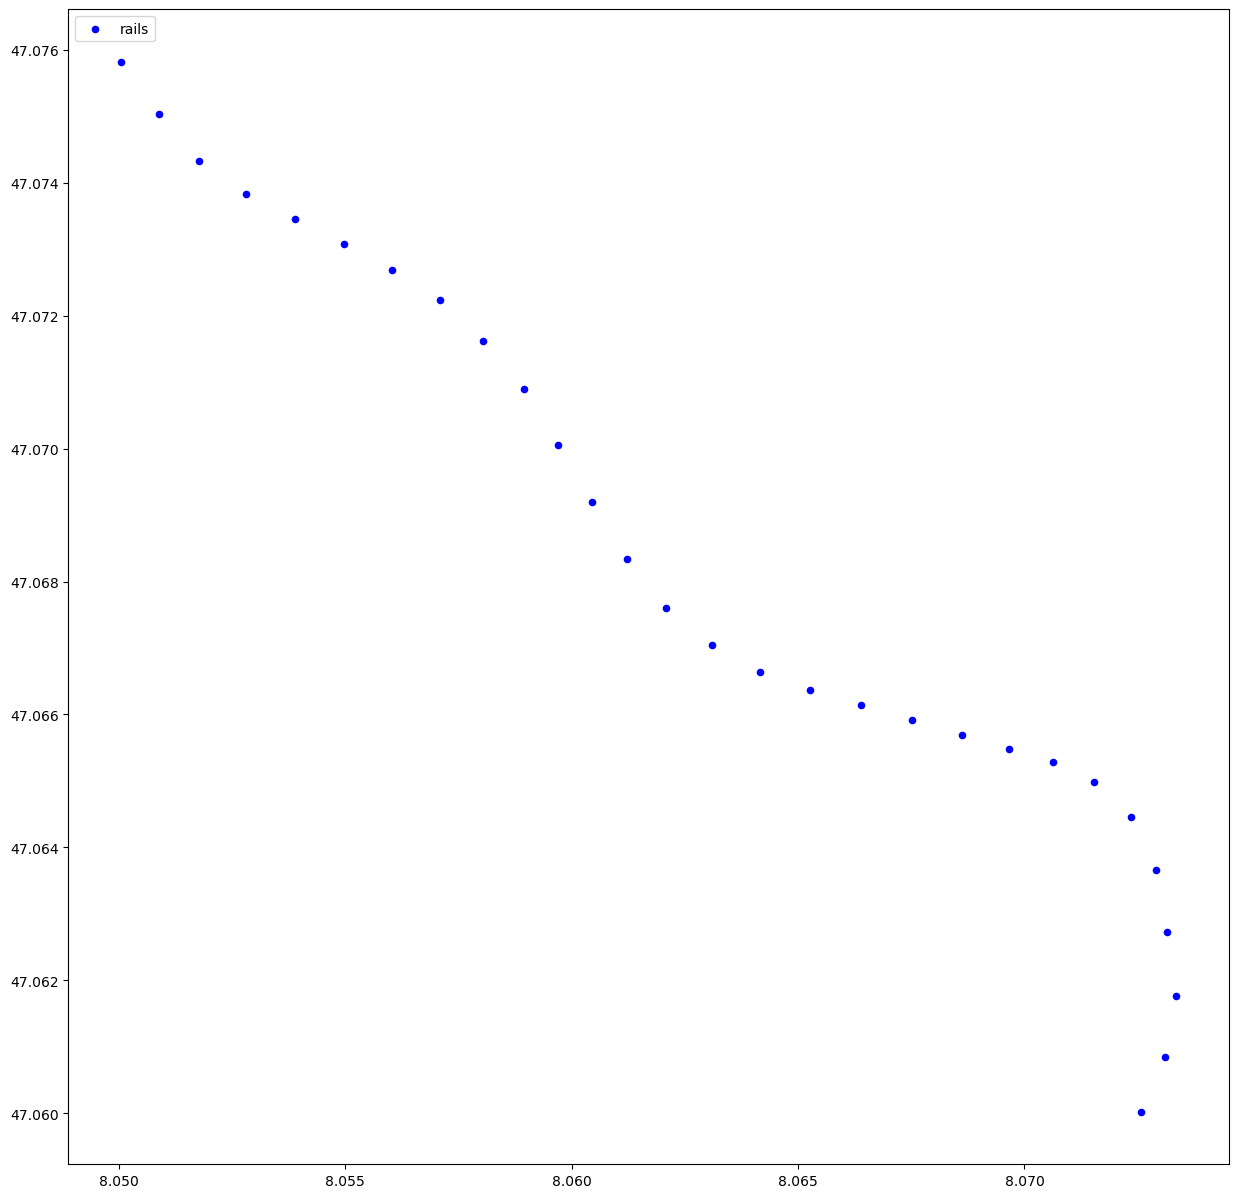

In [36]:
ax = gdf_rails_pnt.set_crs(epsg=4326).cx[ 8.05:8.09, 47.06:47.1].plot(figsize=(15, 15), alpha=1, markersize=20, color='blue', 
                    edgecolor='blue', label='rails')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles, loc='upper left')
plt.show()

2023-03-23 17:50:51,760 - climada.util.lines_polys_handler - WARNING - 2085 lines with a length < 10*resolution were found. Each of these lines is disaggregate to one point. Reaggregatint values will thus likely lead to overestimattion. Consider chosing a smaller resolution or filter out the short lines. 


/Users/evelynm/opt/anaconda3/envs/climada_env/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:122: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


2023-03-23 17:51:03,906 - climada.entity.exposures.base - INFO - Setting latitude and longitude attributes.
2023-03-23 17:51:06,818 - climada.entity.exposures.base - INFO - Matching 137745 exposures with 3057 centroids.
2023-03-23 17:51:06,822 - climada.util.coordinates - INFO - No exact centroid match found. Reprojecting coordinates to nearest neighbor closer than the threshold = 100
2023-03-23 17:51:06,996 - climada.engine.impact_calc - INFO - Calculating impact for 413235 assets (>0) and 1 events.


<AxesSubplot:>

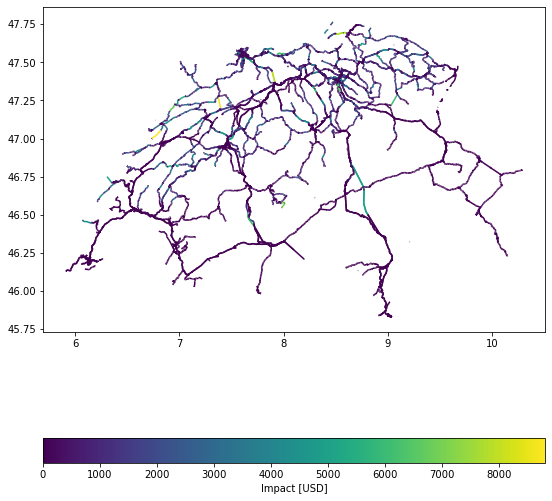

In [23]:
# railways

# all-in-one calculation for lines: 
# interpolate to 100 m resolution, assign each point a fixed value of 100 (metres),
# and re-aggregate the sum of damages to the original exposure format
imp_rails = u_lp.calc_geom_impact(
    exp=exp_rails, impf_set=impf_set, haz=ws_lothar,
    res=100, to_meters=True, disagg_met=u_lp.DisaggMethod.FIX, disagg_val=100,
    agg_met=u_lp.AggMethod.SUM)
# plot the impacts
u_lp.plot_eai_exp_geom(imp_rails)

/Users/evelynm/opt/anaconda3/envs/climada_env/lib/python3.9/site-packages/pandas/core/dtypes/inference.py:383: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  iter(obj)  # Can iterate over it.
/Users/evelynm/opt/anaconda3/envs/climada_env/lib/python3.9/site-packages/pandas/core/dtypes/inference.py:384: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  len(obj)  # Has a length associated with it.
/Users/evelynm/opt/anaconda3/envs/climada_env/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:122: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_a

2023-03-21 14:52:49,818 - climada.entity.exposures.base - INFO - Setting latitude and longitude attributes.
2023-03-21 14:53:16,535 - climada.entity.exposures.base - INFO - Matching 1255598 exposures with 3057 centroids.
2023-03-21 14:53:16,561 - climada.util.coordinates - INFO - No exact centroid match found. Reprojecting coordinates to nearest neighbor closer than the threshold = 100
2023-03-21 14:53:18,176 - climada.engine.impact_calc - INFO - Calculating impact for 3766794 assets (>0) and 1 events.


<AxesSubplot:>

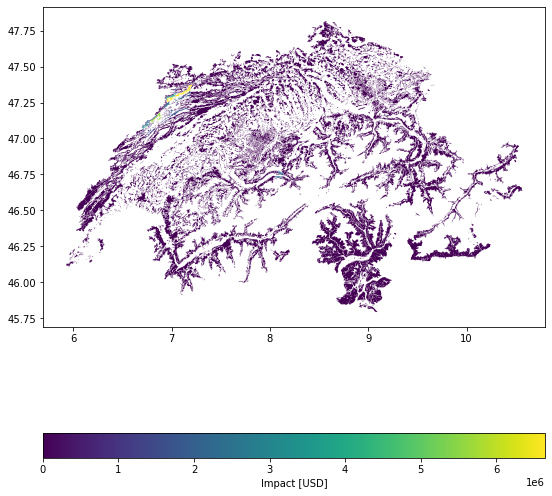

In [253]:
# Forest, with imp func 3 (>42)

imp_forest_42 = u_lp.calc_geom_impact(
    exp=exp_forest_42, impf_set=impf_set, haz=ws_lothar,
    res=100, to_meters=True, disagg_met=u_lp.DisaggMethod.FIX, disagg_val=100*100,
    agg_met=u_lp.AggMethod.SUM
)

# plot results.
u_lp.plot_eai_exp_geom(imp_forest_42)

/Users/evelynm/opt/anaconda3/envs/climada_env/lib/python3.9/site-packages/pandas/core/dtypes/inference.py:383: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  iter(obj)  # Can iterate over it.
/Users/evelynm/opt/anaconda3/envs/climada_env/lib/python3.9/site-packages/pandas/core/dtypes/inference.py:384: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  len(obj)  # Has a length associated with it.
/Users/evelynm/opt/anaconda3/envs/climada_env/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:122: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_a

2023-03-21 14:41:22,741 - climada.entity.exposures.base - INFO - Setting latitude and longitude attributes.
2023-03-21 14:41:49,033 - climada.entity.exposures.base - INFO - Matching 1255598 exposures with 3057 centroids.
2023-03-21 14:41:49,060 - climada.util.coordinates - INFO - No exact centroid match found. Reprojecting coordinates to nearest neighbor closer than the threshold = 100
2023-03-21 14:41:50,524 - climada.engine.impact_calc - INFO - Calculating impact for 3766794 assets (>0) and 1 events.


<AxesSubplot:>

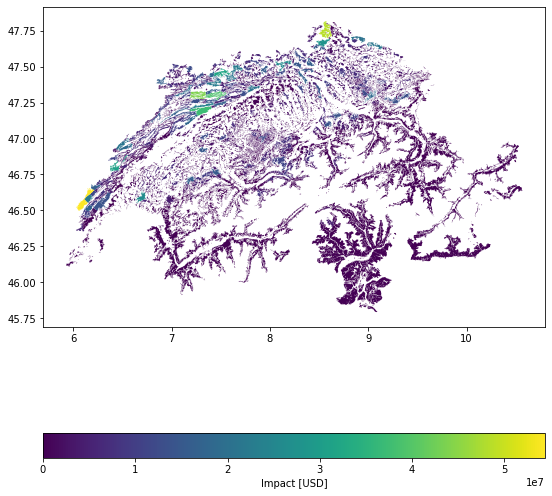

In [235]:
# Forest, with imp func 2 (>30.5)

imp_forest_W4 = u_lp.calc_geom_impact(
    exp=exp_forest_W4, impf_set=impf_set, haz=ws_lothar,
    res=100, to_meters=True, disagg_met=u_lp.DisaggMethod.FIX, disagg_val=100*100,
    agg_met=u_lp.AggMethod.SUM
)

# plot results.
u_lp.plot_eai_exp_geom(imp_forest_W4)

/Users/evelynm/opt/anaconda3/envs/climada_env/lib/python3.9/site-packages/pandas/core/dtypes/inference.py:383: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  iter(obj)  # Can iterate over it.
/Users/evelynm/opt/anaconda3/envs/climada_env/lib/python3.9/site-packages/pandas/core/dtypes/inference.py:384: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  len(obj)  # Has a length associated with it.
/Users/evelynm/opt/anaconda3/envs/climada_env/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:122: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_a

2023-03-21 15:00:19,888 - climada.entity.exposures.base - INFO - Setting latitude and longitude attributes.
2023-03-21 15:00:48,246 - climada.entity.exposures.base - INFO - Matching 1255598 exposures with 3057 centroids.
2023-03-21 15:00:48,266 - climada.util.coordinates - INFO - No exact centroid match found. Reprojecting coordinates to nearest neighbor closer than the threshold = 100
2023-03-21 15:00:49,969 - climada.engine.impact_calc - INFO - Calculating impact for 3766794 assets (>0) and 1 events.


<AxesSubplot:>

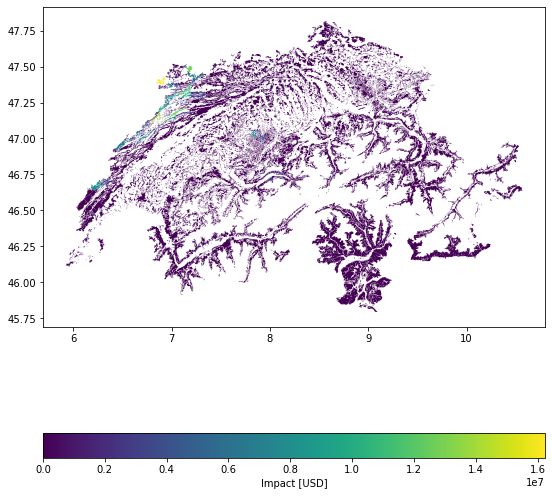

In [259]:
# Forest, with imp func 4 (>W5)

imp_forest_W5 = u_lp.calc_geom_impact(
    exp=exp_forest_W5, impf_set=impf_set, haz=ws_lothar,
    res=100, to_meters=True, disagg_met=u_lp.DisaggMethod.FIX, disagg_val=100*100,
    agg_met=u_lp.AggMethod.SUM
)

# plot results.
u_lp.plot_eai_exp_geom(imp_forest_W5)

2023-03-21 15:32:20,416 - climada.entity.exposures.base - INFO - Matching 11 exposures with 3057 centroids.
2023-03-21 15:32:20,419 - climada.util.coordinates - INFO - No exact centroid match found. Reprojecting coordinates to nearest neighbor closer than the threshold = 100
2023-03-21 15:32:20,425 - climada.engine.impact_calc - INFO - Calculating impact for 33 assets (>0) and 1 events.


<GeoAxesSubplot:title={'center':'Expected annual impact'}>

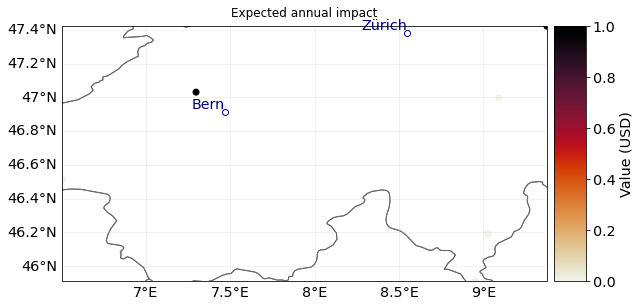

In [271]:
# Unesco heritage sites
imp_unesco = ImpactCalc(exp_unesco, impf_set, ws_lothar).impact()
imp_unesco.plot_scatter_eai_exposure()

2023-03-21 16:41:13,203 - climada.entity.exposures.base - INFO - Matching 70287 exposures with 3057 centroids.
2023-03-21 16:41:13,216 - climada.util.coordinates - INFO - No exact centroid match found. Reprojecting coordinates to nearest neighbor closer than the threshold = 100
2023-03-21 16:41:13,295 - climada.engine.impact_calc - INFO - Calculating impact for 204882 assets (>0) and 1 events.


<GeoAxesSubplot:title={'center':'Expected annual impact'}>

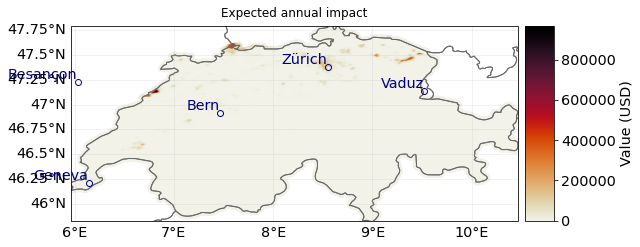

In [307]:
imp_lp = ImpactCalc(exp_lp, impf_set, ws_lothar).impact()
imp_lp.plot_scatter_eai_exposure()

2023-03-21 16:41:16,128 - climada.entity.exposures.base - INFO - Matching 70287 exposures with 3057 centroids.
2023-03-21 16:41:16,131 - climada.util.coordinates - INFO - No exact centroid match found. Reprojecting coordinates to nearest neighbor closer than the threshold = 100
2023-03-21 16:41:16,210 - climada.engine.impact_calc - INFO - Calculating impact for 204882 assets (>0) and 1 events.


<GeoAxesSubplot:title={'center':'Expected annual impact'}>

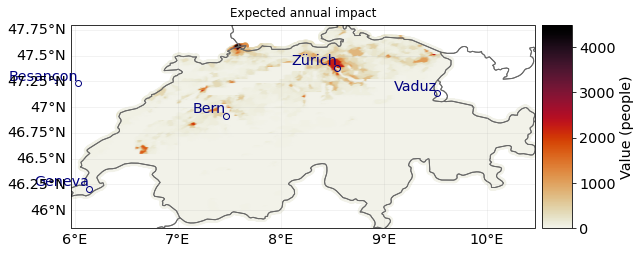

In [308]:
imp_pop = ImpactCalc(exp_pop, impf_set, ws_lothar).impact()
imp_pop.plot_scatter_eai_exposure()

### Summary table

In [309]:
summary_table = pd.DataFrame()
summary_table['exposure'] = ['Asset Values', 'Population', 'Healthcare Facilities', 'Airports','UNESCO world heritage sites',
                             'Railways', 'Forest Area (>W5)']
summary_table['event_impact'] = [imp.aai_agg for imp in [imp_lp, imp_pop, imp_health, imp_airport, imp_unesco,
                                                         imp_rails, imp_forest_W5]]
summary_table['metric'] = ['USD', 'people', 'units', 'units','units', 'm', 'm2']

In [310]:
summary_table

exposure  event_impact  metric
0                 Asset Values  1.794103e+08     USD
1                   Population  4.175326e+06  people
2        Healthcare Facilities  6.490000e+02   units
3                     Airports  6.000000e+00   units
4  UNESCO world heritage sites  3.000000e+00   units
5                     Railways  1.022020e+07       m
6            Forest Area (>W5)  4.646000e+08      m2

In [313]:
len(gdf_health)

1155

In [287]:
imp_airport.aai_agg/len(gdf_airports)

0.4

In [26]:
1.022020e+07/6951700.0
25.4/1.47

17.27891156462585

In [24]:
print(imp_rails.aai_agg)
imp_rails.aai_agg/(len(gdf_rails_pnt)*100)

6951700.0


0.504678935714545

In [288]:
imp_unesco.aai_agg/len(gdf_unesco)

0.2727272727272727

In [297]:
imp_forest_W5.aai_agg/12555980000

0.037002288949170035

In [315]:
len(gdf_unesco)

11

In [298]:
imp_health.aai_agg/len(gdf_health)

0.5619047619047619

In [311]:
imp_pop.aai_agg/exp_pop.gdf.value.sum()

0.57596355218776

In [302]:
imp_lp.aai_agg/exp_lp.gdf.value.sum()*100

0.009916493528833262

## Verification Data

In [231]:
# building damage estimated: 600 million
imp_lp.aai_agg / 6e8

0.3881141868304329

In [262]:
# reported forest damage: 46000 ha (ca. 4.3% of total forest area)
# Damage value: 750 million 
area_forest_imp = 46000*10000
# total estimated forest area CH
area_forest_tot = area_forest_imp/0.043
# value per m2 of forest
val_per_m2_forest = 750*1e6/area_forest_imp

print('Areas OSM vs. Areas estimated CH', 12555980000/10000000000 )

print('Forest with 42m/s thresh: ', imp_forest_42.aai_agg/area_forest_imp)
print('Forest with > W4 thresh: ',imp_forest_W4.aai_agg/area_forest_imp)
print('Forest with > W5 thresh: ',imp_forest_W5.aai_agg/area_forest_imp)

Areas OSM vs. Areas estimated CH 1.255598
Forest with 42m/s thresh:  0.17547826086956522
Forest with > W4 thresh:  10.709108695652175
Forest with > W5 thresh:  1.01


In [ ]:
"""
Durch umstürzende Bäume und Fahrleitungsrisse wurden zahlreiche Eisenbahnverbindungen in der 
gesamten Deutschschweiz unterbrochen. 
Die SBB hielten den Betrieb jedoch entsprechend den Umständen auf den nicht betroffenen Linien aufrecht. 
"""